In [1]:
data_dir = './New Plant Diseases Dataset'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = './test'

In [2]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from keras.utils.np_utils import to_categorical
import numpy as np
import os, shutil
import scipy

2023-12-20 16:23:02.490738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 16:23:02.564713: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-20 16:23:02.999757: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:
2023-12-20 16:23:02.999840: W tensorflow/compiler/xla/stream_executor/

In [3]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [4]:
# GPU Utilization
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tensorflow.config.experimental.set_virtual_device_configuration(gpus[0], [
            tensorflow.config.experimental.VirtualDeviceConfiguration(memory_limit=6800)])  # 2000MB=2GB
    except RuntimeError as e:
        print(e)

2023-12-20 16:23:03.577252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-20 16:23:03.581402: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-20 16:23:03.581769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
newpath = './/test_files' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

x = os.listdir(train_dir)
for dir_names in x:
  # print(dir_names)
  p = os.listdir(os.path.join(train_dir, dir_names))
  if not os.path.exists(os.path.join(newpath, dir_names)):
    os.makedirs(os.path.join(newpath, dir_names))
  cnt = 0
  file_names = []
  for image_names in p:
    if cnt==250:
      break
    file_names.append(train_dir+'/'+dir_names+'/'+image_names)
    cnt += 1
  for f in file_names:
    shutil.move(f, os.path.join(newpath, dir_names))
    



In [6]:
train_datagen = ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen = ImageDataGenerator()

train = train_datagen.flow_from_directory(directory=train_dir,batch_size=4,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid = val_datagen.flow_from_directory(directory=valid_dir,batch_size=4,target_size=(224,224),color_mode='rgb',class_mode='categorical')

test_datagen = ImageDataGenerator()

test = test_datagen.flow_from_directory(directory=test_dir,batch_size=4,target_size=(224,224),color_mode='rgb',class_mode='categorical')

Found 13295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.
Found 33 images belonging to 1 classes.


In [7]:
base_model_tf=EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=38)

2023-12-20 16:23:05.076109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 16:23:05.076525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-20 16:23:05.076931: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-20 16:23:05.077197: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

In [8]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float64)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(38,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [9]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [10]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [11]:
model_main.fit(train,validation_data=valid,epochs=30,steps_per_epoch=200,verbose=1,callbacks=[es, lr])

Epoch 1/30


2023-12-20 16:23:19.957677: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-12-20 16:23:21.032661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-12-20 16:23:21.033769: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x1c4acac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-20 16:23:21.033783: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-12-20 16:23:21.036676: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-20 16:23:21.103848: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the 

200/200 [==============================] - 85s 396ms/step - loss: 2.7328 - accuracy: 0.2800 - val_loss: 2.0191 - val_accuracy: 0.3986 - lr: 0.0010
Epoch 2/30
200/200 [==============================] - 78s 394ms/step - loss: 1.4554 - accuracy: 0.5600 - val_loss: 1.1996 - val_accuracy: 0.6556 - lr: 0.0010
Epoch 3/30
200/200 [==============================] - 78s 391ms/step - loss: 0.9762 - accuracy: 0.7138 - val_loss: 1.0615 - val_accuracy: 0.6872 - lr: 0.0010
Epoch 4/30
200/200 [==============================] - 78s 390ms/step - loss: 0.7932 - accuracy: 0.7350 - val_loss: 0.8347 - val_accuracy: 0.7343 - lr: 0.0010
Epoch 5/30
200/200 [==============================] - 78s 392ms/step - loss: 0.6667 - accuracy: 0.7975 - val_loss: 0.8367 - val_accuracy: 0.7437 - lr: 0.0010
Epoch 6/30
200/200 [==============================] - 78s 392ms/step - loss: 0.6060 - accuracy: 0.8150 - val_loss: 0.7185 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 7/30
200/200 [==============================] - 78s 390ms

In [12]:
model_main.save("efficientnetv2s_PLANT_DISEASE.h5")

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
# import cv2
# from PIL import Image

Text(0.5, 1.0, 'model loss')

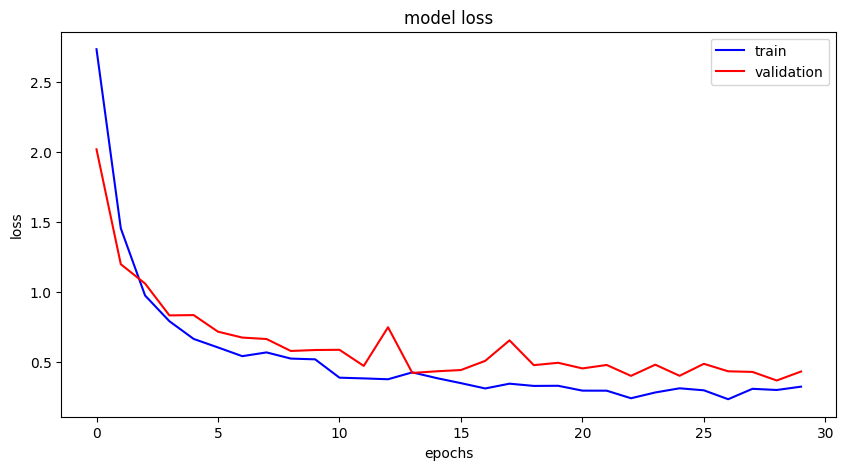

In [15]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

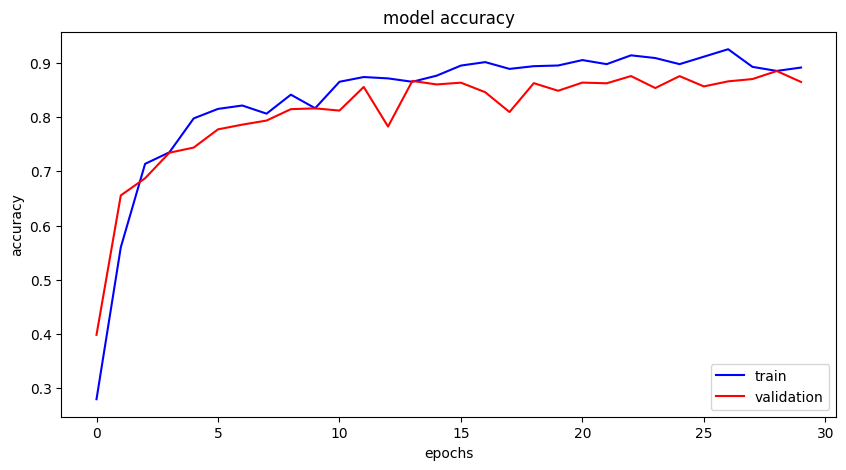

In [16]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [17]:
loss, accuracy = model_main.evaluate(train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(valid, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

3324/3324 [==============================] - 61s 18ms/step - loss: 0.2586 - accuracy: 0.9150
Train: accuracy = 0.915006  ;  loss = 0.258617
4393/4393 [==============================] - 84s 19ms/step - loss: 0.4345 - accuracy: 0.8647
Validation: accuracy = 0.864671  ;  loss = 0.434473
9/9 [==============================] - 1s 63ms/step - loss: 573.6985 - accuracy: 0.0909
Test: accuracy = 0.090909  ;  loss = 573.698547


In [19]:
model = load_model("efficientnetv2s_PLANT_DISEASE.h5")

In [23]:
img = tensorflow.keras.utils.load_img(
    "./test/test/PotatoEarlyBlight1.JPG",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model.predict(input_arr)

1/1 [==============================] - 1s 1s/step


In [24]:
probability_model = tensorflow.keras.Sequential([model, 
                                         tensorflow.keras.layers.Softmax()])

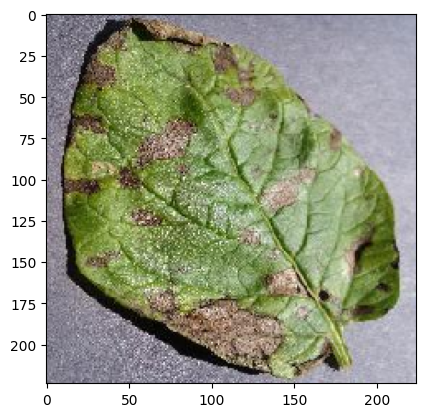

In [33]:
plt.imshow(img)

In [25]:
predict = probability_model.predict(input_arr)

1/1 [==============================] - 1s 1s/step


In [26]:
predict[0]

array([0.025205  , 0.02520452, 0.02520369, 0.0252036 , 0.02520361,
       0.0252045 , 0.02520359, 0.02520363, 0.02520359, 0.0252036 ,
       0.02520359, 0.02520363, 0.0252036 , 0.02520677, 0.02520359,
       0.02520359, 0.02520377, 0.02520359, 0.0252562 , 0.02520361,
       0.06684459, 0.02544637, 0.02520362, 0.0252036 , 0.02520359,
       0.02520361, 0.02520812, 0.02520359, 0.02520679, 0.02532383,
       0.02522751, 0.0252036 , 0.02536953, 0.02520364, 0.02520592,
       0.02520362, 0.02520359, 0.0252036 ], dtype=float32)

In [27]:
classes = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [28]:
p = np.argmax(predict[0])
print(classes[p])

Potato___Early_blight
